In [1]:
import numpy as np
import pandas as pd
import PySAM.Pvsamv1 as pv

import matplotlib.pyplot as plt

In [2]:
pvmodel = pv.default('PVBatteryResidential')

In [3]:
# there are formatting differences between the weather file that we download from
# pvwatts and what SAM wants --- SAM wants the file from the NSRDB 
pvmodel.SolarResource.solar_resource_file = "../data/tmy_5.579_-0.233_2005_2014.epw"

In [4]:
our_load_profile = np.loadtxt("../data/Max_load_profile_for_year.txt", skiprows=1)

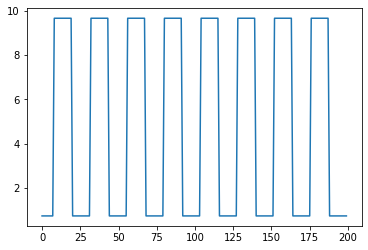

In [5]:
plt.plot(our_load_profile[:200])

In [6]:
pvmodel.Load.load = tuple(our_load_profile)

In [7]:
pvmodel.Module.module_model = 1 # set it to CEC model

In [8]:
pvmodel.CECPerformanceModelWithModuleDatabase.export()

{'cec_a_ref': 2.42033,
 'cec_adjust': 4.86979,
 'cec_alpha_sc': 0.002492,
 'cec_area': 1.631,
 'cec_array_cols': 10.0,
 'cec_array_rows': 1.0,
 'cec_backside_temp': 20.0,
 'cec_beta_oc': -0.16975,
 'cec_bifacial_ground_clearance_height': 1.0,
 'cec_bifacial_transmission_factor': 0.013,
 'cec_bifaciality': 0.65,
 'cec_gamma_r': -0.31,
 'cec_gap_spacing': 0.05,
 'cec_heat_transfer': 0.0,
 'cec_height': 0.0,
 'cec_i_l_ref': 6.23681,
 'cec_i_mp_ref': 5.85,
 'cec_i_o_ref': 3.99e-12,
 'cec_i_sc_ref': 6.23,
 'cec_is_bifacial': 0.0,
 'cec_module_length': 1.631,
 'cec_module_width': 1.0,
 'cec_mounting_config': 0.0,
 'cec_mounting_orientation': 0.0,
 'cec_n_s': 96.0,
 'cec_r_s': 0.499389,
 'cec_r_sh_ref': 457.185,
 'cec_standoff': 6.0,
 'cec_t_noct': 46.4,
 'cec_temp_corr_mode': 0.0,
 'cec_transient_thermal_model_unit_mass': 11.0919,
 'cec_v_mp_ref': 57.3,
 'cec_v_oc_ref': 67.9}

In [9]:
# calculating the total number of modules reqd for the overall system capacity

# module_power = V_mpp * I_mpp
mod_power = 5.85 * 57.3

no_of_modules = 10_000 / mod_power # system capacity needed/ module_power

no_of_modules

29.83249056547486

In [74]:
pvmodel.Inverter.inverter_model = 0. # set it to CEC

pvmodel.Inverter.inv_num_mppt = 1 # use different mmpts

In [75]:
# inverter settings 
pvmodel.Inverter.export()

{'inv_cec_cg_eff_cec': 96.6364,
 'inv_cec_cg_paco': 3800.0,
 'inv_ds_eff': 96.0,
 'inv_ds_paco': 4000.0,
 'inv_num_mppt': 1.0,
 'inv_pd_eff': 95.0,
 'inv_pd_paco': 4000.0,
 'inv_snl_eff_cec': 97.0529,
 'inv_snl_paco': 3850.0,
 'inverter_count': 1.0,
 'inverter_model': 0.0,
 'mppt_hi_inverter': 480.0,
 'mppt_low_inverter': 100.0}

In [76]:
# Calculating the number of modules required per 
# string to satisfy the lower and upper limits of inverter capacity

# high = mmpt_hi_inverter / V_OC_module
module_per_string_high = 480/67.9

# low = mmpt_low_inverter / V_OC_module
module_per_string_low = 100/67.9

module_per_string_low, module_per_string_high

(1.4727540500736376, 7.069219440353461)

In [77]:
# arranging 30 modules in (2 to 7) strings

number_of_modules_per_string = 6
number_of_strings = 5

Refer [this link](https://sam.nrel.gov/images/webinar_files/sam-webinars-2020-modeling-pv-systems.pdf) for detailed explanation on MMPT, subarray, strings, etc

In [78]:
# System Design
pvmodel.SystemDesign.inverter_count = 1

pvmodel.SystemDesign.subarray1_modules_per_string = 6
pvmodel.SystemDesign.subarray1_nstrings = 5
pvmodel.SystemDesign.subarray1_mppt_input = 1

pvmodel.SystemDesign.subarray2_modules_per_string = 6
pvmodel.SystemDesign.subarray2_nstrings = 5
pvmodel.SystemDesign.subarray2_mppt_input = 1

# pvmodel.SystemDesign.subarray3_modules_per_string = 5
# pvmodel.SystemDesign.subarray3_nstrings = 0

In [79]:
pvmodel.SystemDesign.export()

{'enable_mismatch_vmax_calc': 0.0,
 'inverter_count': 1.0,
 'subarray1_azimuth': 180.0,
 'subarray1_backtrack': 0.0,
 'subarray1_gcr': 0.3,
 'subarray1_modules_per_string': 6.0,
 'subarray1_monthly_tilt': (40.0,
  40.0,
  40.0,
  20.0,
  20.0,
  20.0,
  20.0,
  20.0,
  20.0,
  40.0,
  40.0,
  40.0),
 'subarray1_mppt_input': 1.0,
 'subarray1_nstrings': 5.0,
 'subarray1_rotlim': 45.0,
 'subarray1_tilt': 20.0,
 'subarray1_tilt_eq_lat': 0.0,
 'subarray1_track_mode': 0.0,
 'subarray2_azimuth': 180.0,
 'subarray2_backtrack': 0.0,
 'subarray2_enable': 0.0,
 'subarray2_gcr': 0.3,
 'subarray2_modules_per_string': 6.0,
 'subarray2_monthly_tilt': (40.0,
  40.0,
  40.0,
  20.0,
  20.0,
  20.0,
  20.0,
  20.0,
  20.0,
  40.0,
  40.0,
  40.0),
 'subarray2_mppt_input': 1.0,
 'subarray2_nstrings': 5.0,
 'subarray2_rotlim': 45.0,
 'subarray2_tilt': 20.0,
 'subarray2_tilt_eq_lat': 0.0,
 'subarray2_track_mode': 0.0,
 'subarray3_azimuth': 180.0,
 'subarray3_backtrack': 0.0,
 'subarray3_enable': 0.0,
 'sub

In [80]:
# pvmodel.BatterySystem.batt_computed_bank_capacity = 2000

In [81]:
#pvmodel.BatteryCell.export()

In [82]:
pvmodel.execute()

<BarContainer object of 12 artists>

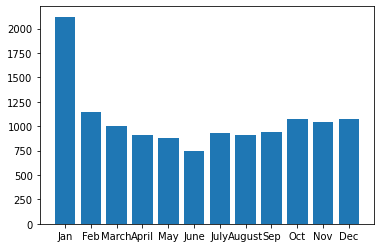

In [83]:
months = ["Jan", "Feb", "March", "April", "May", "June", "July", "August", "Sep", "Oct", "Nov", "Dec"]
plt.bar(months, pvmodel.Outputs.monthly_energy)

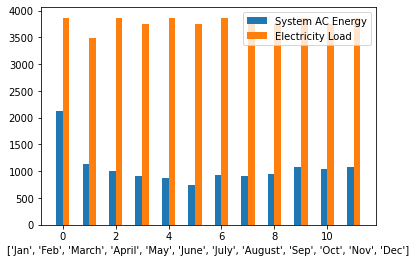

In [45]:
dates = pd.date_range(start="1/1/2006", end="1/1/2007", freq="H").delete(-1)

hourly_load_w_dates = pd.DataFrame({"Load" : pvmodel.Load.load, "Dates" : dates})
monthly_load = hourly_load_w_dates.groupby(hourly_load_w_dates["Dates"].dt.month)["Load"].sum()

months = ["Jan", "Feb", "March", "April", "May", "June", "July", "August", "Sep", "Oct", "Nov", "Dec"]

x = np.arange(len(months))  # the label locations
width = 0.25  # the width of the bars

f, ax = plt.subplots()
ax.bar(x - width/2, pvmodel.Outputs.monthly_energy, width, label="System AC Energy")
ax.bar(x + width/2, monthly_load.values, width, label="Electricity Load")
ax.set_xlabel(months)
plt.legend();

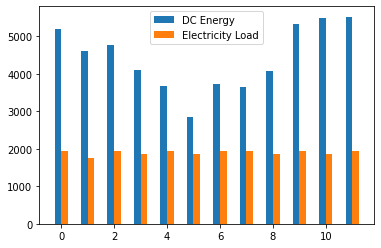

In [47]:
# Monthly DC energy (apparently SAM is plotting this) ---- different from "MOnthly Energy" 
f, ax = plt.subplots()
ax.bar(x - width/2, pvmodel.Outputs.monthly_dc, width, label="DC Energy")
ax.bar(x + width/2, monthly_load.values, width, label="Electricity Load")
plt.legend();

In [39]:
diff_of_energy_load = pvmodel.Outputs.monthly_energy - monthly_load.values

diff_of_energy_load

array([1086.07588122, 2660.05884864, 2605.45126942, 2058.73982632,
       1553.41544931,  799.68477431, 1635.76182659, 1527.92468561,
       2012.21011894, 3181.52291687, 3382.41061585, 3359.97703292])

In [40]:
pvmodel.Outputs.monthly_batt_to_load

(351.55520657021907,
 310.67581992973663,
 342.96930355048863,
 349.4356231743355,
 369.638728493752,
 346.92419089024474,
 334.16589404067264,
 360.7613144909268,
 306.5176602797649,
 349.2117797482001,
 339.66704003260753,
 319.6129346833818)

In [42]:
pvmodel.Outputs.batt_to_load

(0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.4824368590698569,
 4.8355,
 4.8355,
 4.8355,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 4.8355,
 4.8355,
 4.8355,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 1.2370690994209839,
 4.8355,
 4.8355,
 4.8355,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 4.8355,
 4.8355,
 4.8355,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 1.7124357074850511,
 4.8355,
 4.8355,
 4.8355,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0

In [41]:
pvmodel.BatterySystem.batt_computed_bank_capacity

2000.0

In [21]:
max(monthly_load.values)

3867.6840000000057

In [ ]:
# Evaluation

dates = pd.date_range(start="1/1/2006", end="1/1/2007", freq="H").delete(-1)

hourly_load_w_dates = pd.DataFrame({"Load" : pvmodel.Load.load, "Dates" : dates})
monthly_load = hourly_load_w_dates.groupby(hourly_load_w_dates["Dates"].dt.month)["Load"].sum()



def optimize(n_inverters, batt_bank_capacity, modules_per_string, n_strings):
    # System Design
    pvmodel.SystemDesign.inverter_count = n_inverters
    pvmodel.SystemDesign.subarray1_modules_per_string = modules_per_string
    pvmodel.SystemDesign.subarray1_nstrings = n_strings
    pvmodel.BatterySystem.batt_computed_bank_capacity = batt_bank_capacity
    
    pvmodel.execute()